# SST

Time derivative, spatial gradients


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=2)
w = cluster.scale(5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.89:38995 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# 0: load path


In [5]:
grd = load_grd()
ds = load_data('SST')
ds = ds.assign_coords(**grd.coords)
ds0=ds
print(ds)
print('\n data size (all faces): %.1f GB' %(ds['SST'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SST'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<shape=(8785,), chunksize=(1,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    hFacC    (face, j, i) float32 d

## shift in time

In [6]:
ds = ds0

In [7]:
dit, vmax = 2, .4
dt = (ds.time[dit]-ds.time[0]).values
ds['dSST'] = ds.SST.shift(time=2) - ds.SST

In [8]:
ds = ds.isel(time=6000).load()
sli = slice(0,None,4) # required to make worldwide plots, otherwise, half the globe is plotted
ds = ds.isel(i=sli, j=sli, i_g=sli, j_g=sli)
#
ds = ds.drop('dtime') # tmp leads to serialization issue at plots
#
#ds.persist()
#
print(ds)
print('\n dataset size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    iters    int64 1092096
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    time     float64 2.73e+07
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SN       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC       (face, j, i) float32 -114.93228 -114.93183 ... -114.52893
    YC       (face, j, i) float32 -88.17715 -88.18883 ... -88.16518 -88.165405
    hFacC    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (face, j, i) float32 155492.97 155533.44 ... 155872.25 155612.52
    CS       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Z        (k) float32 -0.5 -1.57 -2.79 -4.185 ... -5881.

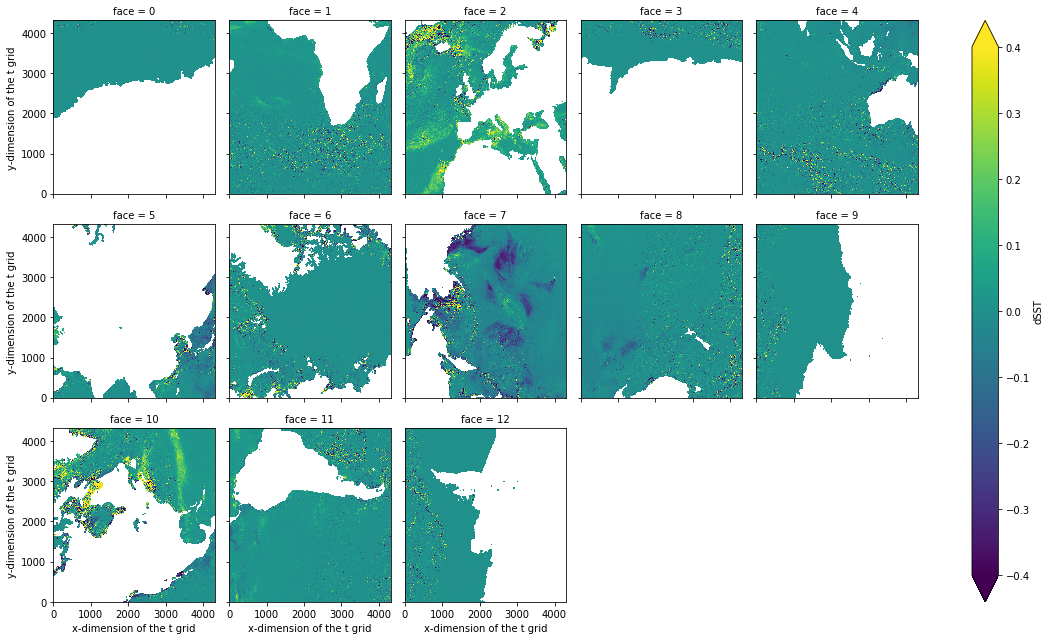

In [9]:
ds.dSST.plot(col='face', col_wrap=5, vmin=-vmax, vmax=vmax)

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b476223a2b0>,
       dtype=object))

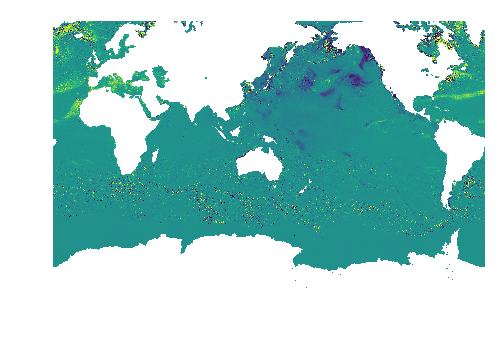

In [10]:
quick_llc_plot(ds.dSST, vmin=-vmax, vmax=vmax, 
               add_colorbar=False, axis_off=True)

(<Figure size 1080x1080 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b476150eba8>)

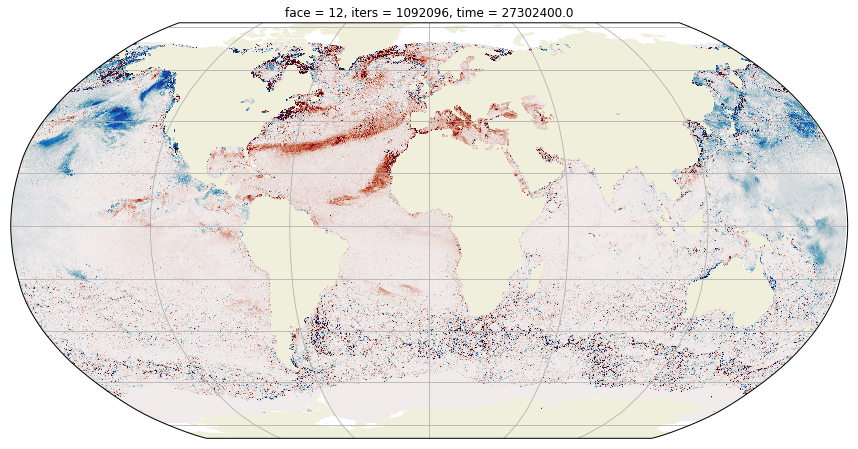

In [11]:
plot_pretty(ds.dSST, vmin=-vmax, vmax=vmax, cmap=cm.balance, 
            ignore_face=[6], colorbar=False)

(<Figure size 1080x1080 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b47f75dc390>)

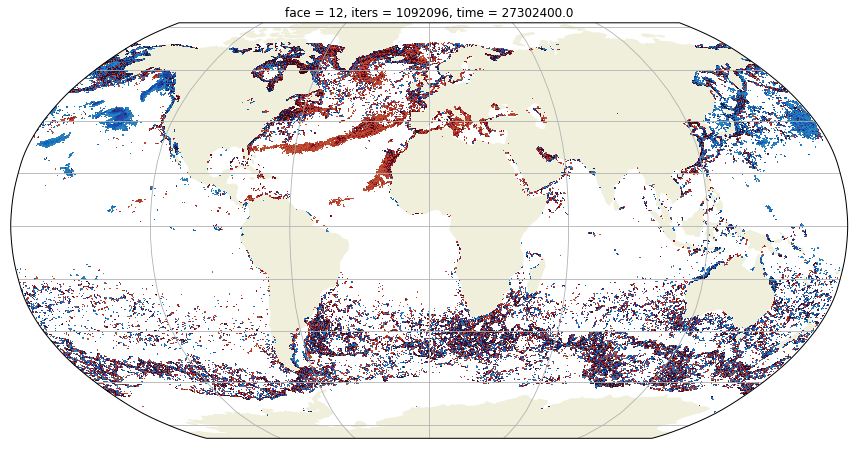

In [16]:
dSST = ds.dSST.where(np.abs(ds.dSST)>.2,drop=False)
plot_pretty(dSST, vmin=-vmax, vmax=vmax, cmap=cm.balance, 
            ignore_face=[6], colorbar=False)

(<Figure size 1080x1080 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b47644cd208>)

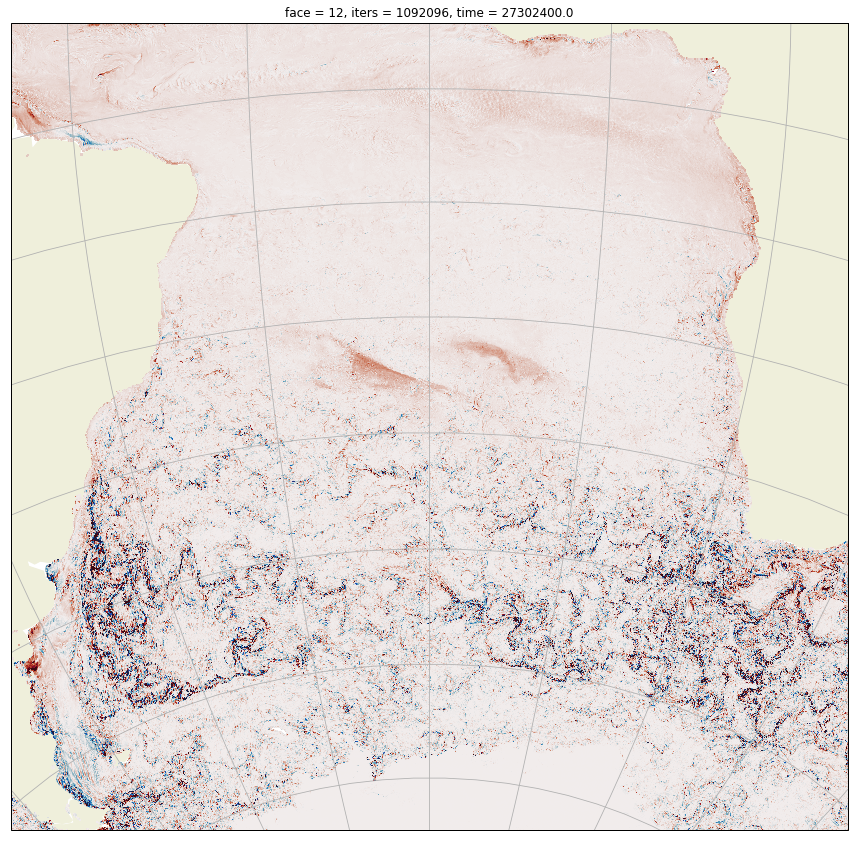

In [12]:
plot_pretty(ds.dSST, vmin=-vmax, vmax=vmax, cmap=cm.balance,
            colorbar=False, region='south-atlantic')

(<Figure size 1080x1080 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b47f7bfc390>)

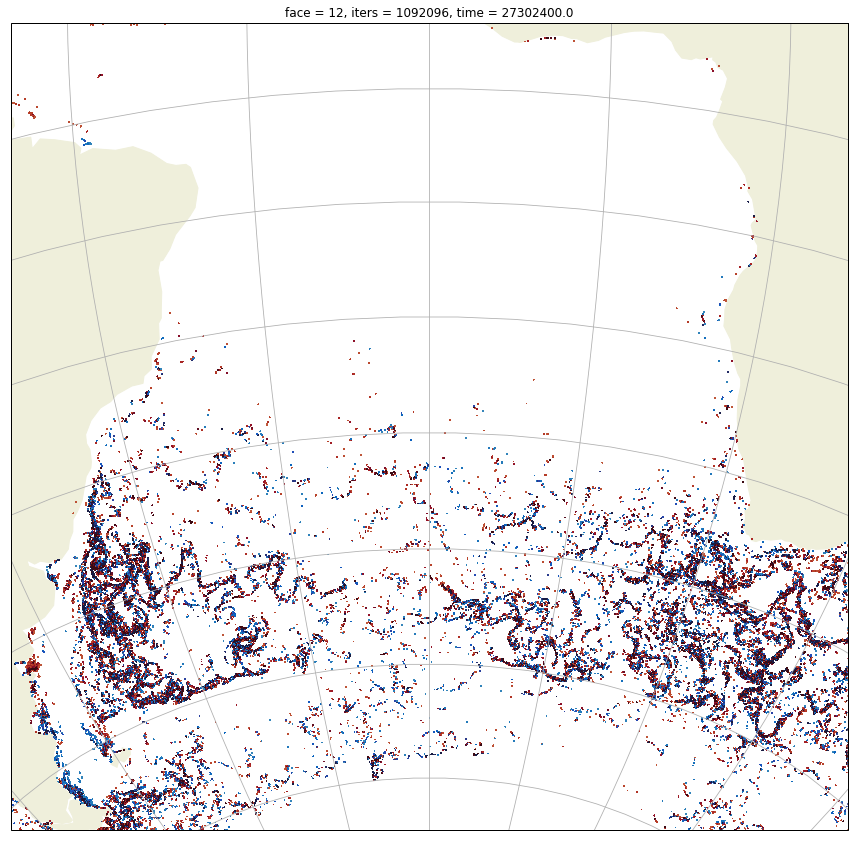

In [17]:
plot_pretty(dSST, vmin=-vmax, vmax=vmax, cmap=cm.balance,
            colorbar=False, region='south-atlantic')

---

In [18]:
# kill scheduler, workers
cluster.close()

qdel: Job has finished



In [14]:
# restart workers
client.restart()

distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://10.135.39.89:38995 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 1 Cores: 2 Memory: 40.00 GB


In [15]:
client

Client Scheduler: tcp://10.135.39.89:38995 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 1 Cores: 2 Memory: 40.00 GB
